In [2]:
import os
import sys
import numpy as np
import torch as th
import torch.nn as nn
from matplotlib import pyplot as plt
import motornet as mn
from matplotlib import animation
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.type_aliases import TensorDict

## Effectors

In [3]:
def build_arm210(verbose=False):
    
    arm210 = mn.effector.Effector(
    skeleton=mn.skeleton.TwoDofArm(),
    muscle=mn.muscle.RigidTendonHillMuscleThelen(),
    integration_method='rk4'
    )

    arm210.add_muscle(
    path_fixation_body=[0., 1.],
    path_coordinates=[[-.15, .03], [.094, 0.017]],
    name='pectoralis',
    max_isometric_force=838,
    tendon_length=.039,
    optimal_muscle_length=.134,
    normalized_slack_muscle_length=1.48)

    arm210.add_muscle(
    path_fixation_body=[0., 1.],
    path_coordinates=[[-.034, .022], [.144, 0.01]],
    name='clavicular deltoid',
    max_isometric_force=680,
    tendon_length=.039,
    optimal_muscle_length=.104,
    normalized_slack_muscle_length=1.4)

    arm210.add_muscle(
    path_fixation_body=[0., 0., 1.],
    path_coordinates=[[.14, 0.], [.05, -.00], [0.153, 0.]],
    name='deltoid',
    max_isometric_force=1207,
    tendon_length=.066,
    optimal_muscle_length=.140,
    normalized_slack_muscle_length=1.52)

    arm210.add_muscle(
    path_fixation_body=[0., 0., 1.],
    path_coordinates=[[.1, 0.], [.05, -.03], [0.062, 0.004]],
    name='teres major',
    max_isometric_force=1207,
    tendon_length=.066,
    optimal_muscle_length=.068,
    normalized_slack_muscle_length=1.65)

    arm210.add_muscle(
    path_fixation_body=[1., 2.],
    path_coordinates=[[0.23, 0.001], [0.231, 0.01]],
    name='brachioradialis',
    max_isometric_force=1422,
    tendon_length=.172,
    optimal_muscle_length=.092,
    normalized_slack_muscle_length=1.43)

    arm210.add_muscle(
    path_fixation_body=[1., 1., 2.],
    path_coordinates=[[0.03, 0.], [0.138, -0.019], [-0.04, -0.017]],
    name='tricepslat',
    max_isometric_force=1549,
    tendon_length=.187,
    optimal_muscle_length=.093,
    normalized_slack_muscle_length=1.45)

    arm210.add_muscle(
    path_fixation_body=[0., 2.],
    path_coordinates=[[-0.052, 0.033], [0.044, 0.001]],
    name='biceps',
    max_isometric_force=414,
    tendon_length=.204,
    optimal_muscle_length=.137,
    normalized_slack_muscle_length=1.5)

    arm210.add_muscle(
    path_fixation_body=[0., 2.],
    path_coordinates=[[0.02, -0.028], [-0.04, -0.017]],
    name='tricepslong',
    max_isometric_force=603,
    tendon_length=0.217,
    optimal_muscle_length=0.127,
    normalized_slack_muscle_length=1.4)

    arm210.add_muscle(
    path_fixation_body=[1., 2.],
    path_coordinates=[[0.306, -0.011], [0.003, -0.025]],
    name='anconeus',
    max_isometric_force=300,
    tendon_length=0.01,
    optimal_muscle_length=0.015,
    normalized_slack_muscle_length=1.72)

    arm210.add_muscle(
    path_fixation_body=[1., 2.],
    path_coordinates=[[0.277, 0.], [0.075, 0.02]],
    name='prot',
    max_isometric_force=700,
    tendon_length=0.02,
    optimal_muscle_length=0.058,
    normalized_slack_muscle_length=1.48)

    if verbose:
      arm210.print_muscle_wrappings()

    return arm210

arm210 = build_arm210(verbose=False)

In [4]:
def build_arm26(verbose=False):

    arm26 = mn.effector.RigidTendonArm26(
       muscle=mn.muscle.MujocoHillMuscle(),
       integration_method='rk4')

    if verbose:
      arm210.print_muscle_wrappings()

    return arm26

arm26 = build_arm26(verbose=True)

MUSCLE NAME: pectoralis
-----------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.15000000596046448, 0.029999999329447746], [0.09399999678134918, 0.017000000923871994]]
max_isometric_force:  838
tendon_length:  0.039
optimal_muscle_length:  0.134
normalized_slack_muscle_length:  1.48


MUSCLE NAME: clavicular deltoid
-------------------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.03400000184774399, 0.02199999988079071], [0.14399999380111694, 0.009999999776482582]]
max_isometric_force:  680
tendon_length:  0.039
optimal_muscle_length:  0.104
normalized_slack_muscle_length:  1.4


MUSCLE NAME: deltoid
--------------------
n_fixation_points:  3
fixation body:  [0, 0, 1]
coordinates:  [[0.14000000059604645, 0.0], [0.05000000074505806, -0.0], [0.15299999713897705, 0.0]]
max_isometric_force:  1207
tendon_length:  0.066
optimal_muscle_length:  0.14
normalized_slack_muscle_length:  1.52


MUSCLE NAME: teres major
-------------------

## State visualization methods

In [5]:
def print_effector_state(effector, batch_size):

    effector.reset(options={"batch_size": batch_size})

    for key, state in effector.states.items():
        print(key + " shape: " + " " * (10-len(key)), state.shape)
    
    print()

def print_muscle_state(effector):

    features = effector.muscle.state_name
    for n, feature in enumerate(features):
        print("feature " + str(n) + ": ", feature)

print_effector_state(arm26, 7)
print_muscle_state(arm26)

joint shape:       torch.Size([7, 4])
cartesian shape:   torch.Size([7, 4])
muscle shape:      torch.Size([7, 7, 6])
geometry shape:    torch.Size([7, 4, 6])
fingertip shape:   torch.Size([7, 2])

feature 0:  activation
feature 1:  muscle length
feature 2:  muscle velocity
feature 3:  force-length PE
feature 4:  force-length CE
feature 5:  force-velocity CE
feature 6:  force


## Visualize effector structure

In [125]:
def compute_body_positions_and_orientations(skeleton, joint_angles, link_lengths):
    """Computes global positions and orientations for skeleton bodies."""
    theta1, theta2 = joint_angles
    L1, L2 = link_lengths
    
    body_positions = [
        np.array([0., 0.]),  # Shoulder (body 0)
        np.array([L1 * np.cos(theta1), L1 * np.sin(theta1)]),  # Elbow (body 1)
        np.array([L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2),
                    L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)  # Wrist (body 2)
                ])
    ]
    
    body_orientations = [
        theta1,  # Body 0 orientation
        theta1 + theta2,  # Body 1 orientation
        theta1 + theta2   # Body 2 orientation (same as body 1)
    ]
    
    return body_positions, body_orientations

def plot_skeleton(ax, skeleton, joint_angles, link_lengths):
    """Plots the arm skeleton segments."""
    L1, L2 = link_lengths
    theta1, theta2 = joint_angles
    
    # Shoulder to elbow
    elbow_x = L1 * np.cos(theta1)
    elbow_y = L1 * np.sin(theta1)
    ax.plot([0, elbow_y], [0, elbow_x], 'k-', lw=4, label='Upper Arm')
    
    # Elbow to wrist
    wrist_x = elbow_x + L2 * np.cos(theta1 + theta2)
    wrist_y = elbow_y + L2 * np.sin(theta1 + theta2)
    ax.plot([elbow_y, wrist_y], [elbow_x, wrist_x], 'k-', lw=4, label='Forearm')
    
    # Plot joints
    ax.plot(0, 0, 'ko', markersize=10, label='Shoulder')
    ax.plot(elbow_y, elbow_x, 'ko', markersize=8, label='Elbow')
    ax.plot(wrist_y, wrist_x, 'ko', markersize=6, label='Wrist')

def get_muscle_points(muscle, body_positions, body_orientations):
    """Computes global coordinates for muscle path points."""
    points = []
    for body_idx, (x, y) in zip(muscle.path_fixation_body, muscle.path_coordinates):
        body_pos = body_positions[int(body_idx)]
        angle = body_orientations[int(body_idx)]
        
        # Rotate local coordinates
        x_rot = x * np.cos(angle) - y * np.sin(angle)
        y_rot = x * np.sin(angle) + y * np.cos(angle)
        
        # Translate to global position
        points.append((body_pos[0] + x_rot, body_pos[1] + y_rot))
    return points

def plot_effector_structure(effector, joint_angles=np.zeros(2), link_lengths=(0.3, 0.33)) :
    """Plots the 2D structure of the effector with muscles in different colors."""
    skeleton = effector.skeleton
    
    # Compute body positions and orientations
    body_positions, body_orientations = compute_body_positions_and_orientations(skeleton, joint_angles, link_lengths)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_aspect('equal')
    ax.set_title("Effector Structure")
    ax.set_xlim(-0.75, .75)
    ax.set_ylim(-0.2, 1.0)
    
    # Plot skeleton
    plot_skeleton(ax, skeleton, joint_angles, link_lengths)
    
    # Plot muscles
    colors = plt.cm.get_cmap('tab10', effector.n_muscles)
    for i, muscle in enumerate(effector.get_muscle_cfg()):
        print(f'muscle {muscle} and values: {dict[muscle]}')
        points = get_muscle_points(muscle, body_positions, body_orientations)
        x, y = zip(*points)
        ax.plot(x, y, color=colors(i), lw=2, label=muscle.name)
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    

muscle pectoralis and values: {'n_fixation_points': 0, 'fixation body': [], 'coordinates': []}


C:\Users\mauri\AppData\Local\Temp\ipykernel_8588\2877211869.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', effector.n_muscles)


AttributeError: 'str' object has no attribute 'path_fixation_body'

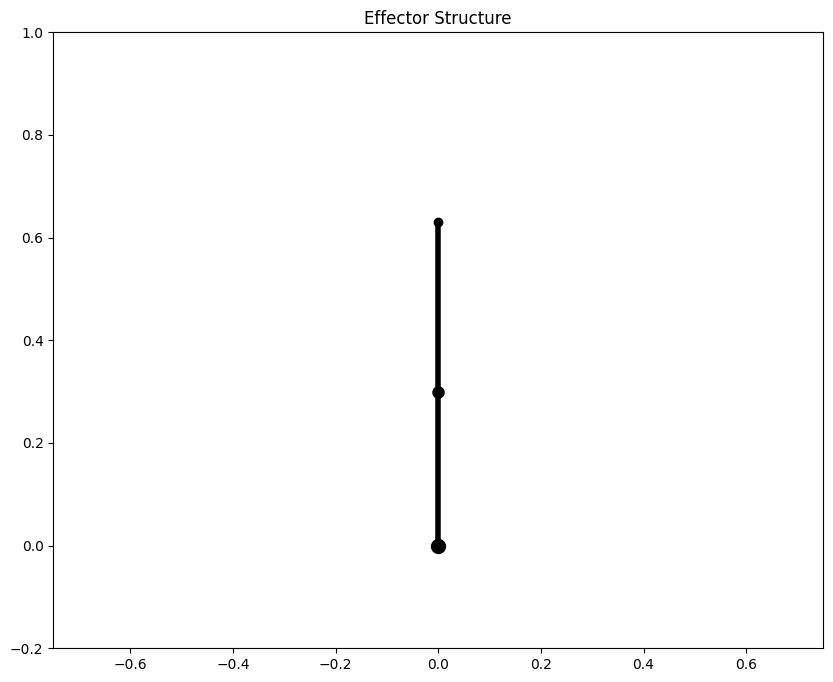

In [126]:
plot_effector_structure(arm26)


In [127]:
def visualize_episode(env, effector, episode_length=100):
    """Animates the effector during an environment episode."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    
    observation, _ = env.reset()
    joint_angles = observation[:2]  # Adjust indices based on your observation space
    
    # Initialize skeleton and muscle lines
    skeleton_lines = init_skeleton_lines(ax, env, joint_angles)
    muscle_lines = init_muscle_lines(ax, effector, env, joint_angles)
    
    def animate(i):
        action = env.action_space.sample()  # Replace with your policy
        observation, _, _, _, _ = env.step(action)
        joint_angles = observation[:2]
        
        update_skeleton(skeleton_lines, env, joint_angles)
        update_muscles(muscle_lines, effector, env, joint_angles)
        
        return [*skeleton_lines, *muscle_lines]
    
    ani = animation.FuncAnimation(
        fig, animate,
        frames=episode_length,
        interval=50, blit=True
    )
    plt.show()

def init_skeleton_lines(ax, env, joint_angles):
    """Initializes skeleton plot elements."""
    lines = [
        ax.plot([], [], 'k-', lw=4)[0],  # Upper arm
        ax.plot([], [], 'k-', lw=4)[0],  # Forearm
        ax.plot([], [], 'ko', markersize=10)[0],  # Shoulder
        ax.plot([], [], 'ko', markersize=8)[0],  # Elbow
        ax.plot([], [], 'ko', markersize=6)[0],  # Wrist
    ]
    update_skeleton(lines, env, joint_angles)
    return lines

def update_skeleton(lines, env, joint_angles):
    """Updates skeleton positions."""
    L1, L2 = env.effector.skeleton.link_lengths
    theta1, theta2 = joint_angles
    
    elbow_x = L1 * np.cos(theta1)
    elbow_y = L1 * np.sin(theta1)
    wrist_x = elbow_x + L2 * np.cos(theta1 + theta2)
    wrist_y = elbow_y + L2 * np.sin(theta1 + theta2)
    
    # Update lines
    lines[0].set_data([0, elbow_x], [0, elbow_y])  # Upper arm
    lines[1].set_data([elbow_x, wrist_x], [elbow_y, wrist_y])  # Forearm
    lines[2].set_data([0], [0])  # Shoulder
    lines[3].set_data([elbow_x], [elbow_y])  # Elbow
    lines[4].set_data([wrist_x], [wrist_y])  # Wrist

def init_muscle_lines(ax, effector, env, joint_angles):
    """Initializes muscle plot elements."""
    colors = plt.cm.get_cmap('tab10', len(effector.muscles))
    lines = [ax.plot([], [], lw=2, color=colors(i))[0] for i in range(len(effector.muscles))]
    update_muscles(lines, effector, env, joint_angles)
    return lines

def update_muscles(lines, effector, env, joint_angles):
    """Updates muscle positions."""
    body_positions, body_orientations = compute_body_positions_and_orientations(
        env.effector.skeleton, joint_angles)
    
    for i, muscle in enumerate(effector.muscles):
        points = get_muscle_points(muscle, body_positions, body_orientations)
        x, y = zip(*points)
        lines[i].set_data(x, y)

AttributeError: 'TwoDofArm' object has no attribute 'link_lengths'

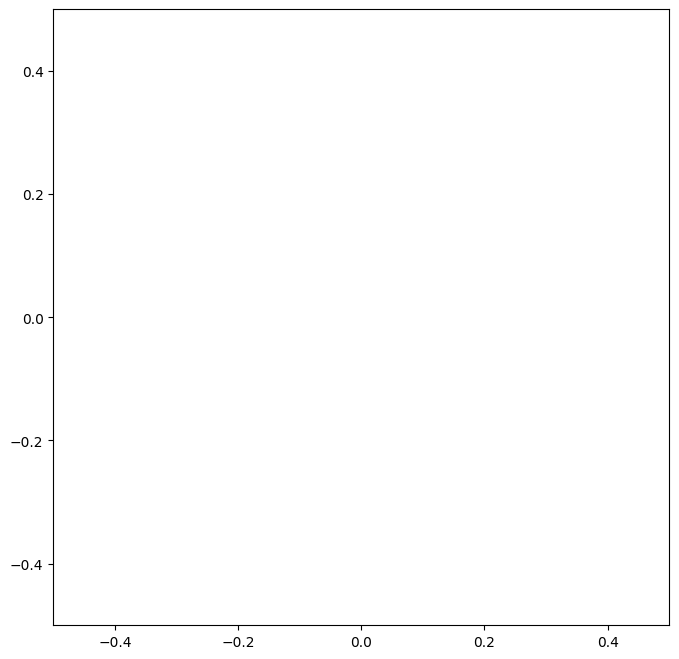

In [128]:
# Create your environment
env = mn.environment.Environment(effector=arm210, max_ep_duration=1.)

# Animate a random episode
visualize_episode(env, arm210, episode_length=200)

## Visualize muscle lengths

In [6]:
def visualize_muscle_len(effector):

    n_states = 21  # grid resolution
    sho, elb = np.meshgrid(
        np.linspace(effector.pos_lower_bound[0], effector.pos_upper_bound[0], n_states).astype('float32'),
        np.linspace(effector.pos_lower_bound[1], effector.pos_upper_bound[1], n_states).astype('float32'))
    sho, elb = th.tensor(sho), th.tensor(elb)
    effector.reset(options={"joint_state": th.stack([sho.reshape(-1), elb.reshape(-1)], axis=1)})
    mstate = effector.states["muscle"].numpy().reshape((n_states, n_states, -1, effector.n_muscles))
    gstate = effector.states["geometry"].numpy().reshape((n_states, n_states, -1, effector.n_muscles))
    sho, elb = th.tensor(sho), th.tensor(elb)

    fig = plt.figure(figsize=(22, 7))
    fig.patch.set_facecolor('xkcd:white')
    # fig.set_tight_layout(True)
    for m in range(effector.n_muscles):
        ax = fig.add_subplot(2, 5, m+1, projection='3d')
        ax.plot_surface(sho, elb, mstate[:, :, 1, m], cmap=plt.get_cmap('coolwarm'))
        ax.set_xlabel('shoulder angle (rad)')
        ax.set_ylabel('elbow angle (rad)')
        ax.set_zlabel('muscle length (m)')
        ax.view_init(18, -40)
        ax.locator_params(nbins=6)
        plt.title(effector.muscle_name[m])
    plt.show()

def visualize_muscle_moments(effector):
    # create a grid of joint angles
    n_states = 21  # grid resolution
    sho, elb = np.meshgrid(
        np.linspace(effector.pos_lower_bound[0], effector.pos_upper_bound[0], n_states).astype('float32'),
        np.linspace(effector.pos_lower_bound[1], effector.pos_upper_bound[1], n_states).astype('float32'))
    sho, elb = th.tensor(sho), th.tensor(elb)

    effector.reset(options={"joint_state": th.stack([sho.reshape(-1), elb.reshape(-1)], axis=1)})
    mstate = effector.states["muscle"].numpy().reshape((n_states, n_states, -1, effector.n_muscles))
    gstate = effector.states["geometry"].numpy().reshape((n_states, n_states, -1, effector.n_muscles))
    sho, elb = th.tensor(sho), th.tensor(elb)

    fig = plt.figure(figsize=(22, 7))
    fig.patch.set_facecolor('xkcd:white')
    # fig.set_tight_layout(True)
    for m in range(effector.n_muscles):
        ax = fig.add_subplot(2, 5, m+1, projection='3d')
        ax.plot_surface(sho, elb, gstate[:, :, 2, m] * 100, cmap=plt.get_cmap('coolwarm'))
        ax.plot_surface(sho, elb, gstate[:, :, 3, m] * 100, cmap=plt.get_cmap('coolwarm'))
        ax.set_xlabel('shoulder angle (rad)')
        ax.set_ylabel('elbow angle (rad)')
        ax.set_zlabel('moment arm (cm)')
        ax.view_init(18, -40)
        ax.locator_params(nbins=6)
        plt.title(effector.muscle_name[m])
plt.show()

C:\Users\mauri\AppData\Local\Temp\ipykernel_10840\2472127185.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sho, elb = th.tensor(sho), th.tensor(elb)


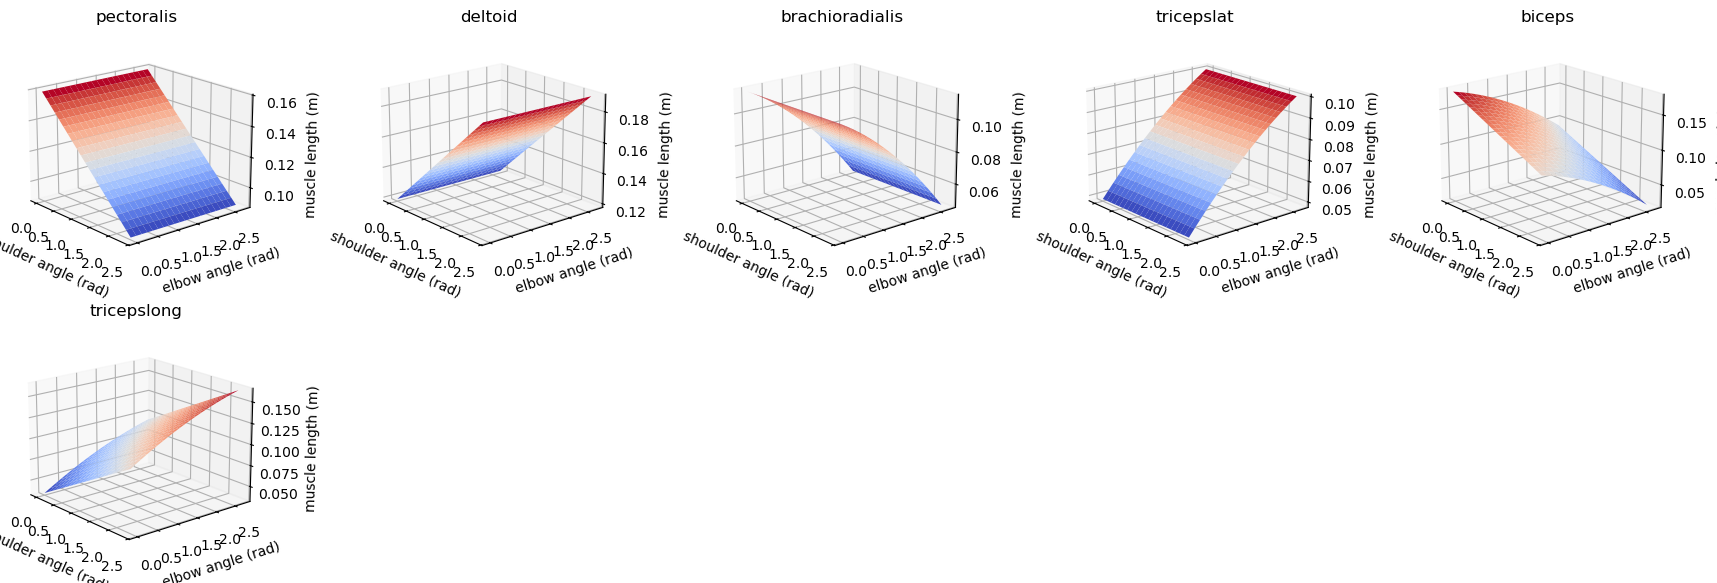

In [7]:
visualize_muscle_len(arm26)

C:\Users\mauri\AppData\Local\Temp\ipykernel_10840\2472127185.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sho, elb = th.tensor(sho), th.tensor(elb)


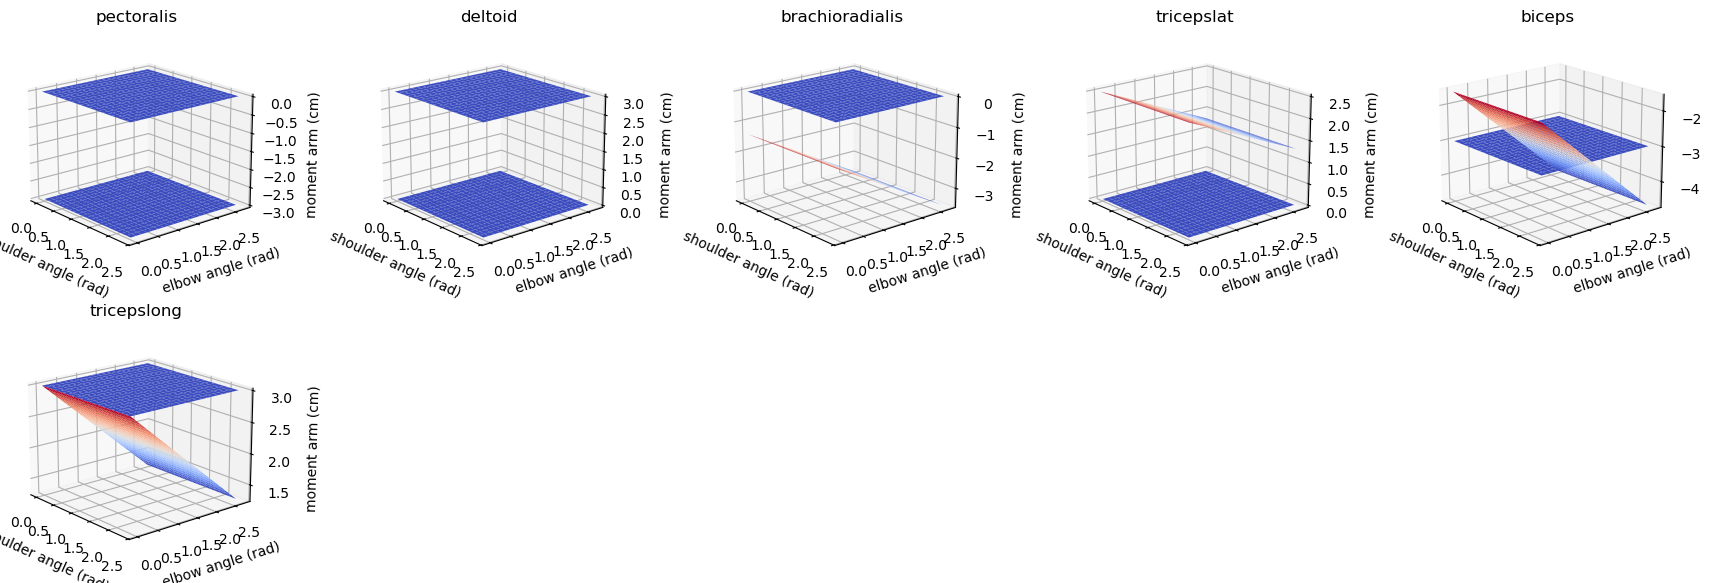

In [8]:
visualize_muscle_moments(arm26)

## environment

In [135]:
env = mn.environment.RandomTargetReach(effector=arm26, max_ep_duration=1.)

## Networks

In [ ]:
class Policy(th.nn.Module):

    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, device, sigma=0.1):
        super().__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = 1
        self.sigma = sigma
        self.noise = th.zeros(output_dim, device = device)
        self.timestep_counter = 0
        self.resample_threshold = np.random(16, 24)
        self.gru = nn.GRU(input_dim, hidden_dim, 1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

        # Apply custom initialization
        for name, param in self.named_parameters():
            
            if "gru" in name:
                if "weight_ih" in name:
                    nn.init.orthogonal_(param)
                elif "weight_hh" in name:
                    nn.init.orthogonal_(param)
                elif "bias_ih" in name:
                    nn.init.zeros_(param)
                elif "bias_hh" in name:
                    nn.init.zeros_(param)
            elif "fc" in name:
                if "weight" in name:
                    nn.init.orthogonal_(param)
                elif "bias" in name:
                    nn.init.constant_(param, -10.0)
            else:
                raise ValueError(f"Unexpected parameter: {name}")
        
        self.to(device)

    def forward(self, x, h0):
        y, h = self.gru(x.unsqueeze(1), h0)  
        u = self.sigmoid(self.fc(y.squeeze(1))) 

        # Apply periodic Gaussian noise
        self.timestep_counter += 1
        if self.timestep_counter >= self.resample_threshold:
            self.resample_noise()

        return u + self.noise, h
    
    def resample_noise(self):

        self.noise = th.randn_like(self.noise) * self.sigma
        self.timestep_counter = 0
        self.resample_threshold = np.random.uniform(16, 24)
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        return hidden
    
class CriticNetwork(th.nn.Module):
    def __init__(self, input_size, device):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Tanh(100, 64)
        self.fc3 = nn.Tanh(64, 64)
        self.fc4 = nn.Linear(64, 1)
        self.device = device

        # Apply orthogonal initialization
        self._initialize_weights()

        self.to(device)

    def _initialize_weights(self):
        """Apply orthogonal initialization with gain=1 and bias=0."""
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.orthogonal_(layer.weight, gain=1)  # Orthogonal init with gain=1
            nn.init.zeros_(layer.bias)  # Bias = 0

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return self.fc4(x)

class GRUActorCriticPolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, **kwargs):
        super().__init__(observation_space, action_space, lr_schedule, **kwargs)
        self._build_network()
        self.hidden_states = None  # Stores hidden states during rollout

    def _build_network(self):
        input_dim = self.observation_space.shape[0]
        self.action_dim = self.action_space.shape[0]
        self.hidden_dim = 64  # Match your GRU hidden size

        # Actor (GRU-based) and Critic
        self.actor = Policy(input_dim, self.hidden_dim, self.action_dim, self.device)
        self.critic = CriticNetwork(input_dim, self.device)

        # Initialize action distribution (adjust based on your action space)
        self.action_dist = DiagGaussianDistribution(self.action_dim)

    def forward(self, obs, deterministic=False):
        # Handle hidden states (simplified for example)
        batch_size = obs.shape[0]
        if self.hidden_states is None:
            self.hidden_states = self.actor.init_hidden(batch_size)
        
        # Forward through actor and critic
        actions, new_hidden = self.actor(obs, self.hidden_states)
        values = self.critic(obs)
        self.hidden_states = new_hidden.detach()  # Detach to prevent BPTT

        # Create action distribution (example for continuous actions)
        log_std = th.ones_like(actions) * self.log_std
        self.action_dist = DiagGaussianDistribution(actions, log_std)
        return actions, values, self.action_dist.log_prob(actions)

    def evaluate_actions(self, obs, actions, hidden_states):
        # Evaluate actions for training
        action_pred, _ = self.actor(obs, hidden_states)
        values = self.critic(obs)
        log_std = th.ones_like(action_pred) * self.log_std
        dist = DiagGaussianDistribution(action_pred, log_std)
        log_prob = dist.log_prob(actions)
        entropy = dist.entropy()
        return values, log_prob, entropy

    def predict_values(self, obs):
        return self.critic(obs)


In [ ]:
ppo_kwargs = {
    "policy": GRUActorCriticPolicy,  # Use the custom network
    "learning_rate": 3e-4,
    "n_steps": 2048,
    "batch_size": 128,  # Batch size set to 128
    "n_epochs": 10,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "use_sde": False,
    "policy_kwargs": {"enable_critic_lstm": True},  # Enable GRU in policy
}

## Training Networks in tutorials

In [6]:
policy = Policy(env.observation_space.shape[0], 32, env.n_muscles, device='cpu')
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

In [23]:
batch_size = 32
n_batch = 6000
losses = []
interval = 250

def l1(x, y):
  """L1 loss"""
  return th.mean(th.sum(th.abs(x - y), dim=-1))

def l2(x, y):
  """L2 loss"""
  return th.mean(th.sum(x**2 - y**2), dim=-1)

for batch in range(n_batch):
  # initialize batch
  h = policy.init_hidden(batch_size=batch_size)
  obs, info = env.reset(options={"batch_size": batch_size})
  terminated = False

  # initial positions and targets
  xy = [info["states"]["fingertip"][:, None, :]]
  tg = [info["goal"][:, None, :]]

  # simulate whole episode
  while not terminated:  # will run until `max_ep_duration` is reached
    action, h = policy(obs, h)
    obs, reward, terminated, truncated, info = env.step(action=action)

    xy.append(info["states"]["fingertip"][:, None, :])  # trajectories
    tg.append(info["goal"][:, None, :])  # targets

  # concatenate into a (batch_size, n_timesteps, xy) tensor
  xy = th.cat(xy, axis=1)
  tg = th.cat(tg, axis=1)
  loss = l1(xy, tg)  # L1 loss on position
  
  # backward pass & update weights
  optimizer.zero_grad() 
  loss.backward()
  th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
  optimizer.step()
  losses.append(loss.item())

  if (batch % interval == 0) and (batch != 0):
    print("Batch {}/{} Done, mean policy loss: {}".format(batch, n_batch, sum(losses[-interval:])/interval))

Batch 250/6000 Done, mean policy loss: 0.3383630543351173


KeyboardInterrupt: 

In [ ]:
def plot_training_log(log):
  fig, axs = plt.subplots(1, 1)
  fig.set_tight_layout(True)
  fig.set_size_inches((8, 3))

  axs.semilogy(log)

  axs.set_ylabel("Loss")
  axs.set_xlabel("Batch #")
  plt.show()

plot_training_log(losses)

## Training Networks in practice

In [ ]:
def default_reward(states, goals):
    fingertip_pos = states['fingertip']
    return -th.norm(fingertip_pos - goals, dim=-1)

## Evaluating performance

In [ ]:
plotor = mn.plotor.plot_pos_over_time

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.ylim([-1.1, 1.1])
  plt.xlim([-1.1, 1.1])
  plotor(axis=plt.gca(), cart_results=xy)
  plt.scatter(target_x, target_y)

  plt.subplot(1,2,2)
  plt.ylim([-2, 2])
  plt.xlim([-2, 2])
  plotor(axis=plt.gca(), cart_results=xy - target_xy)
  plt.axhline(0, c="grey")
  plt.axvline(0, c="grey")
  plt.xlabel("X distance to target")
  plt.ylabel("Y distance to target")
  plt.show()


plot_simulations(xy=th.detach(xy), target_xy=th.detach(tg))